In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pickle
import os
import argparse
import logging
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from models import SetTransformer, DeepSet
from mixture_of_mvns import MixtureOfMVNs
from mvn_diag import MultivariateNormalDiag
from matplotlib.patches import Rectangle
from plots import draw_ellipse
import matplotlib.cm as cm

In [6]:
#Select hyperparameters
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net_name = 'set_transformer'
num_bench=100
B=10
N_min=150
N_max=300
K=4

num_inds=16
dim_hidden=128

gpu='0'
lr=5e-4
run_name='trial'
num_steps=20000
test_freq=200
lr_freq = 5000
save_freq=400
D = 4

#*****************#
dim_output = D + 2
#*****************#

save_dir = os.path.join('results', net_name, run_name)
benchfile = os.path.join('benchmark', 'mog_{:d}.pkl'.format(K))

In [7]:
#Build mixtures generator

mvn = MultivariateNormalDiag(D)
mog = MixtureOfMVNs(mvn)
net = SetTransformer(D, K, dim_output, num_inds = num_inds, dim_hidden=dim_hidden).to(device)

In [ ]:
print(net)

In [4]:
#Useful functions

def generate_benchmark():
    if not os.path.isdir('benchmark'):
        os.makedirs('benchmark')
    N_list = np.random.randint(N_min, N_max, num_bench)
    data = []
    ll = 0.
    for N in tqdm(N_list):
        X, labels, pi, params = mog.sample(B, N, K, return_gt=True)
        ll += mog.log_prob(X, pi, params).item()
        data.append(X)
    bench = [data, ll/num_bench]
    torch.save(bench, benchfile)

def train():
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    if not os.path.isfile(benchfile):
        generate_benchmark()

    bench = torch.load(benchfile)
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(run_name)
    logger.addHandler(logging.FileHandler(
        os.path.join(save_dir,
            'train_'+time.strftime('%Y%m%d-%H%M')+'.log'),
        mode='w'))

    optimizer = optim.Adam(net.parameters(), lr=lr)
    tick = time.time()
    for t in range(1, num_steps+1):
        #if t == int(0.5*num_steps):
        if t % lr_freq == 0:
            optimizer.param_groups[0]['lr'] *= 0.1
        net.train()
        optimizer.zero_grad()
        N = np.random.randint(N_min, N_max)
        X = mog.sample(B, N, K)
        Y = net(X)
        #print('Output of the set transformer is of dim {}'.format(Y.size()))
        ll = mog.log_prob(X, *mvn.parse(Y))
        loss = -ll
        loss.backward()
        optimizer.step()

        if t % test_freq == 0:
            line = 'step {}, lr {:.3e}, '.format(
                    t, optimizer.param_groups[0]['lr'])
            line += test(bench, verbose=False)
            line += ' ({:.3f} secs)'.format(time.time()-tick)
            tick = time.time()
            logger.info(line)

        if t % save_freq == 0:
            torch.save({'state_dict':net.state_dict()},
                    os.path.join(save_dir, 'model.tar'))

    torch.save({'state_dict':net.state_dict()},
        os.path.join(save_dir, 'model.tar'))

def test(bench, verbose=True):
    net.eval()
    data, oracle_ll = bench
    avg_ll = 0.
    for X in data:
        X = X.to(device)
        avg_ll += mog.log_prob(X, *mvn.parse(net(X))).item()
    avg_ll /= len(data)
    line = 'test ll {:.4f} (oracle {:.4f})'.format(avg_ll, oracle_ll)
    if verbose:
        logging.basicConfig(level=logging.INFO)
        logger = logging.getLogger(run_name)
        logger.addHandler(logging.FileHandler(
            os.path.join(save_dir, 'test.log'), mode='w'))
        logger.info(line)
    return line

def plot():
    net.eval()
    X = mog.sample(B, np.random.randint(N_min, N_max), K)
    pi, params = mvn.parse(net(X))
    ll, labels = mog.log_prob(X, pi, params, return_labels=True)
    #fig, axes = plt.subplots(B//2, 2, figsize=(7*B//5,7*B//5))
    fig, axes = plt.subplots(2, B//2, figsize=(2*7*B//5, 2*5))
    mog.plot(X, labels, params, axes)
    plt.show()

In [8]:
train()

INFO:trial:step 200, lr 5.000e-04, test ll -33.5868 (oracle 1.4786) (2.943 secs)
INFO:trial:step 400, lr 5.000e-04, test ll -30.2134 (oracle 1.4786) (2.908 secs)
INFO:trial:step 600, lr 5.000e-04, test ll -23.8537 (oracle 1.4786) (2.901 secs)
INFO:trial:step 800, lr 5.000e-04, test ll -18.8898 (oracle 1.4786) (2.863 secs)
INFO:trial:step 1000, lr 5.000e-04, test ll -16.7574 (oracle 1.4786) (2.864 secs)
INFO:trial:step 1200, lr 5.000e-04, test ll -13.9818 (oracle 1.4786) (2.870 secs)
INFO:trial:step 1400, lr 5.000e-04, test ll -13.2871 (oracle 1.4786) (2.955 secs)
INFO:trial:step 1600, lr 5.000e-04, test ll -12.2204 (oracle 1.4786) (2.980 secs)
INFO:trial:step 1800, lr 5.000e-04, test ll -12.9737 (oracle 1.4786) (2.911 secs)
INFO:trial:step 2000, lr 5.000e-04, test ll -11.3792 (oracle 1.4786) (2.883 secs)
INFO:trial:step 2200, lr 5.000e-04, test ll -13.8788 (oracle 1.4786) (2.949 secs)
INFO:trial:step 2400, lr 5.000e-04, test ll -10.4983 (oracle 1.4786) (2.880 secs)
INFO:trial:step 2600

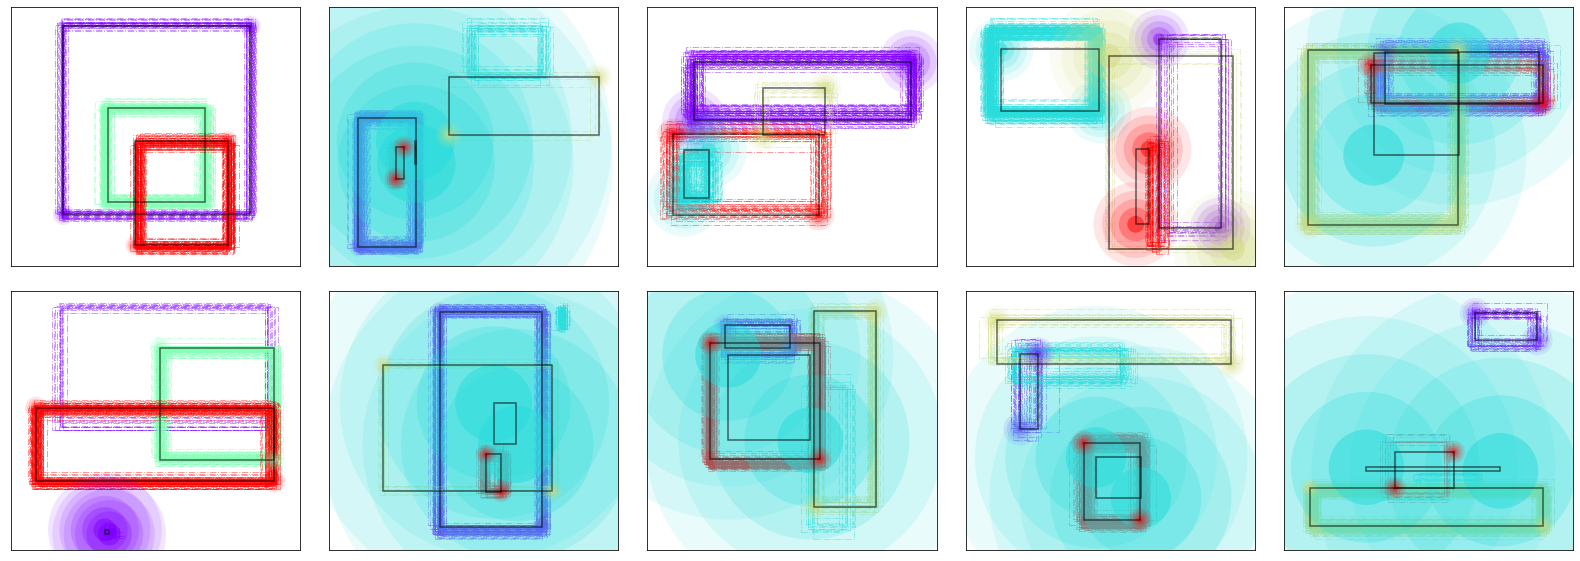

In [9]:
ckpt = torch.load(os.path.join(save_dir, 'model.tar'))
net.load_state_dict(ckpt['state_dict'])
plot()

In [ ]:
#Customize the plot functions to handle the four dimensional case

D = 4
mvn = MultivariateNormalDiag(D)
mog = MixtureOfMVNs(mvn)


#define base rectangles in format (coordinates upper left, coordinates bottom right)
'''
rect1 = torch.tensor([0, 1, 2, 0])
rect2 = torch.tensor([1, 2, 4, 0.5])
rect3 = torch.tensor([2, 6, 4, 3])
rects = torch.vstack((rect1, rect2, rect3))
'''

rects = -4 + 8*torch.rand(3, 4).to(device)

#augment the base rectangles with noise
cov = 0.1
rects_augm = torch.cat((rects[0,:].repeat(10, 1), 
                        rects[1,:].repeat(10, 1), 
                        rects[2,:].repeat(10, 1)), 
                       0)

rects_augm += cov*torch.randn_like(rects_augm)

labels = torch.cat((torch.tensor(0).repeat(10, 1), 
                        torch.tensor(1).repeat(10, 1), 
                        torch.tensor(2).repeat(10, 1)), 
                       0)


X = rects_augm.unsqueeze(0).repeat(10, 1, 1)
labels_X = labels.unsqueeze(0).repeat(10, 1, 1)


#Model a set transformer prediction
mu = rects.clone()
mu_X = mu.unsqueeze(0).repeat(10, 1, 1)
cov_X = torch.tensor(cov).unsqueeze(0).unsqueeze(0).repeat(10, 3, 1)

params = (mu_X, cov_X)


fig, axes = plt.subplots(10//2, 2, figsize=(2*5, 7*10//5))
mog.plot(X, labels_X, params, axes)


In [ ]:
mu_im = mu_X[0, :]
print(mu_im)
X = torch.hstack((mu_im[:, 0].unsqueeze(1), mu_im[:, 2].unsqueeze(1)))
Y = torch.hstack((mu_im[:, 1].unsqueeze(1), mu_im[:, 3].unsqueeze(1)))
print(X)
print(Y)
x_min, _ = torch.min(X, 1)
y_min, _ = torch.min(Y, 1)
x_max, _ = torch.max(X, 1)
y_max, _ = torch.max(Y, 1)
w = x_max - x_min
h = y_max - y_min
print(x_min)
print(y_min)
print(w)
print(h)
ret = torch.hstack(
        (x_min.unsqueeze(1),
        y_min.unsqueeze(1),
        w.unsqueeze(1),
        h.unsqueeze(1))
        
    )
print(ret)